In [1]:
import numpy as np
from scipy.linalg import fractional_matrix_power

# ---- Synthetic Data Generation ----
def generate_synthetic_data(d, N_train, N_test, sigma=5.0):
    """
    Generate synthetic data for a linear model with Gaussian random noise.
    The user can set 'sigma' to control the scale of the random draws.
    Returns:
        theta_actual: ground-truth parameter in R^d
        X_train     : shape (N_train, d)
        y_train     : shape (N_train,)
        X_test      : shape (N_test, d)
    """
    # Random ground truth
    theta_actual = sigma * np.random.randn(d)

    # Training set
    X_train = sigma * np.random.randn(N_train, d)
    y_train = X_train @ theta_actual + np.random.randn(N_train)

    # Test set
    X_test  = sigma * np.random.randn(N_test, d)

    return theta_actual, X_train, y_train, X_test

# ---- Ridge Regression Estimator ----
def ridge_regression_estimator(X, y, indices, lambda_ridge=1.0):
    """
    Fits a ridge regression model on the subset of points given by 'indices'.
    Returns:
      theta_hat : estimated parameters in R^d
    """
    X_S = X[list(indices), :]
    y_S = y[list(indices)]
    d = X_S.shape[1]
    A = X_S.T @ X_S + 0.02 * np.eye(d)
    theta_hat = np.linalg.inv(A) @ (X_S.T @ y_S)
    return theta_hat

def evaluate_loss(X_test, theta_actual, theta_hat):
    """
    Computes the absolute error for each test sample, returns mean and std.

    Returns: (mean_error, std_error)
    """
    errors = np.abs(X_test @ (theta_actual - theta_hat))  # shape (N_test,)
    return np.mean(errors), np.std(errors)

# ---- DPP-based CEIL (Exponentiated Matrix) ----
def build_dpp_kernel(demo_embeds, test_embed, lambda_dpp=1.0):
    """
    Constructs the conditional DPP kernel matrix L' for numerical data
    such that:
      log det(L') = sum_{i in S} r[i] + lambda_dpp * log det(L_S).

    Steps:
      1) r[i] = dot(demo_embeds[i], test_embed).
      2) L = demo_embeds @ demo_embeds.T
      3) L^lambda
      4) L' = diag(exp(r[i]/2)) @ (L^lambda) @ diag(exp(r[j]/2)).
    """
    # 1) Relevance scores
    r = np.einsum("ij,j->i", demo_embeds, test_embed)  # shape (n,)

    # 2) Base kernel: L
    L = demo_embeds @ demo_embeds.T  # shape (n,n)

    # 3) Raise L to power lambda_dpp
    if abs(lambda_dpp - int(lambda_dpp)) < 1e-12:
        L_lambda = np.linalg.matrix_power(L, int(lambda_dpp))
    else:
        L_lambda = fractional_matrix_power(L, lambda_dpp)

    # 4) Diagonal scaling
    r_clipped = np.clip(r / 2.0, -30, 30)
    D = np.exp(r / 2.0)
    Lprime = (D[:, None] * L_lambda) * D[None, :]

    return Lprime

def dpp_map_inference(Lprime, k_select):
    """
    Greedy MAP inference for DPP.
    Picks items one by one, maximizing the incremental log-det.
    """
    n = Lprime.shape[0]
    selected = []
    current_logdet = 0.0

    def submatrix_logdet(indices):
        if len(indices) == 0:
            return 0.0
        subm = Lprime[np.ix_(indices, indices)]
        sign, val = np.linalg.slogdet(subm)
        if sign <= 0:
            return -1e15  # degenerate or negative => huge penalty
        return val

    candidates = set(range(n))
    for _ in range(k_select):
        best_gain = -1e9
        best_item = None
        for i in candidates:
            new_set = selected + [i]
            gain = submatrix_logdet(new_set) - current_logdet
            if gain > best_gain:
                best_gain = gain
                best_item = i

        # Fallback if best_item is None => all gains were -1e9 => numerical meltdown
        if best_item is None:
            if len(candidates) == 0:
                break  # nothing left
            # Just pick a random candidate to proceed
            best_item = np.random.choice(list(candidates))
            best_gain = 0.0


        selected.append(best_item)
        candidates.remove(best_item)
        current_logdet += best_gain

    return selected

# ---- CEIL Simple (Sir's Method) ----
def ceil_simple_select(demo_embeds, test_embed, k, lambd):
    """
    Implements the 'CEIL Simple' approach:
       x_i = argmax_{x} [ z^T x + lambd * log(1 + x^T V^-1 x) ]
    Reuses the same greedy structure as submodular approaches.
    We'll initialize V_S = lambd * I, just like submodular_diverse_select.
    """
    n, d = demo_embeds.shape
    selected = []
    V_S = 0.02 * np.eye(d)  # Start with lam * I
    candidate_indices = set(range(n))

    for _ in range(k):
        invV_S = np.linalg.inv(V_S)
        best_val = -1e9
        best_idx = None
        for i in candidate_indices:
            x = demo_embeds[i]
            # Relevance: z^T x
            relevance = test_embed @ x
            # Diversity (log(1 + x^T V^-1 x)) scaled by lambd
            denom = 1.0 + x @ invV_S @ x
            score = relevance + lambd * np.log(denom)

            if score > best_val:
                best_val = score
                best_idx = i

        selected.append(best_idx)
        candidate_indices.remove(best_idx)

        # Update V_S
        x_sel = demo_embeds[best_idx]
        V_S = V_S + np.outer(x_sel, x_sel)

    return selected

# ---- Submodular Method (with log) ----
def submodular_diverse_select(demo_embeds, test_embed, k, lambd):
    """
    The selection rule:
       x_i = argmax_{x} (z^T V^-1 x)^2 / [1 + x^T V^-1 x] + lambd * log(1 + x^T V^-1 x).
    We initialize V_S = lambd * I to let 'lambd' scale the identity.
    """
    n = demo_embeds.shape[0]
    d = demo_embeds.shape[1]
    selected = []
    V_S = 0.02 * np.eye(d)
    candidate_indices = set(range(n))

    for _ in range(k):
        invV_S = np.linalg.inv(V_S)
        best_val = -1e9
        best_idx = None
        for i in candidate_indices:
            x = demo_embeds[i]
            numerator = (test_embed @ invV_S @ x)**2
            denom = 1.0 + (x @ invV_S @ x)
            score = numerator / denom + lambd * np.log(denom)
            if score > best_val:
                best_val = score
                best_idx = i
        selected.append(best_idx)
        x_sel = demo_embeds[best_idx]
        V_S = V_S + np.outer(x_sel, x_sel)
        candidate_indices.remove(best_idx)

    return selected

# ---- Submodular Method (no log) ----
def submodular_diverse_select_no_log(demo_embeds, test_embed, k, lambd):
    """
    Variation that uses a linearized diversity:
       x_i = argmax_{x} (z^T V^-1 x)^2 / [1 + x^T V^-1 x] + lambd * [1 + x^T V^-1 x].
    We keep the 'V_S = 0.02 * I' as in your original code.
    """
    n = demo_embeds.shape[0]
    d = demo_embeds.shape[1]
    selected = []
    V_S = 0.02 * np.eye(d)  # fixed small constant

    candidate_indices = set(range(n))
    for _ in range(k):
        invV_S = np.linalg.inv(V_S)
        best_val = -1e9
        best_idx = None
        for i in candidate_indices:
            x = demo_embeds[i]
            numerator = (test_embed @ invV_S @ x)**2
            denom = 1.0 + (x @ invV_S @ x)
            score = numerator / denom + lambd * denom
            if score > best_val:
                best_val = score
                best_idx = i
        selected.append(best_idx)
        candidate_indices.remove(best_idx)

        x_sel = demo_embeds[best_idx]
        V_S = V_S + np.outer(x_sel, x_sel)

    return selected

def experiment(d, N_train, N_test, K, lambda_ridge, lambda_val, sigma=5.0):
    """
    Runs an experiment comparing:
      1) CEIL Actual (DPP + exponentiated matrix)
      2) CEIL Simple (z^T x + lambda log(1 + x^T V^-1 x))
      3) Submodular (with log)
      4) Submodular (no log)

    Inputs:
      d            : dimension
      N_train      : # training points
      N_test       : # test points
      K            : subset size
      lambda_ridge : ridge penalty for the regressor
      lambda_val   : the trade-off parameter for CEIL / Submodular
      sigma        : scale factor for data generation
    """
    # Generate data
    theta_actual, X_train, y_train, X_test = generate_synthetic_data(d, N_train, N_test, sigma=sigma)

    # Convert training inputs as embeddings
    demo_embeds = X_train

    # --- (A) CEIL Actual (DPP approach) ---
    Lprime = build_dpp_kernel(demo_embeds, X_test[0], lambda_dpp=lambda_val)
    indices_dpp = dpp_map_inference(Lprime, k_select=K)
    theta_hat_dpp = ridge_regression_estimator(X_train, y_train, indices_dpp, lambda_ridge)
    dpp_mean, dpp_std = evaluate_loss(X_test, theta_actual, theta_hat_dpp)

    # --- (B) CEIL Simple ---
    indices_ceil_simple = ceil_simple_select(demo_embeds, X_test[0], K, lambd=lambda_val)
    theta_hat_ceil_simple = ridge_regression_estimator(X_train, y_train, indices_ceil_simple, lambda_ridge)
    ceil_simp_mean, ceil_simp_std = evaluate_loss(X_test, theta_actual, theta_hat_ceil_simple)

    # --- (C) Submodular (with log) ---
    indices_submod = submodular_diverse_select(demo_embeds, X_test[0], K, lambd=lambda_val)
    theta_hat_submod = ridge_regression_estimator(X_train, y_train, indices_submod, lambda_ridge)
    submod_log_mean, submod_log_std = evaluate_loss(X_test, theta_actual, theta_hat_submod)

    # --- (D) Submodular (no log) ---
    indices_submod_nolog = submodular_diverse_select_no_log(demo_embeds, X_test[0], K, lambd=lambda_val)
    theta_hat_submod_nolog = ridge_regression_estimator(X_train, y_train, indices_submod_nolog, lambda_ridge)
    submod_nolog_mean, submod_nolog_std = evaluate_loss(X_test, theta_actual, theta_hat_submod_nolog)

    return {
        "ceil_dpp": {
            "indices": indices_dpp,
            "mean_loss": dpp_mean,
            "std_loss": dpp_std,
        },
        "ceil_simple": {
            "indices": indices_ceil_simple,
            "mean_loss": ceil_simp_mean,
            "std_loss": ceil_simp_std,
        },
        "submodular_log": {
            "indices": indices_submod,
            "mean_loss": submod_log_mean,
            "std_loss": submod_log_std,
        },
        "submodular_nolog": {
            "indices": indices_submod_nolog,
            "mean_loss": submod_nolog_mean,
            "std_loss": submod_nolog_std,
        }
    }

In [2]:
# Example usage:
results = experiment(
    d=5,
    N_train=50,
    N_test=50,
    K=5,
    lambda_ridge=1.0,
    lambda_val=2.0,   # the submodular / DPP trade-off
    sigma=5.0         # scale factor for data generation
)

# Print or store the results
for method, info in results.items():
    print(method, " => ",
          "indices:", info["indices"],
          "mean loss:", info["mean_loss"],
          "std loss:", info["std_loss"])


ceil_dpp  =>  indices: [10, 7, 5, 33, 40] mean loss: 3.1752201936883084 std loss: 2.027981968360087
ceil_simple  =>  indices: [10, 7, 5, 33, 40] mean loss: 3.1752201936883084 std loss: 2.027981968360087
submodular_log  =>  indices: [10, 41, 19, 28, 46] mean loss: 1.5487111960477078 std loss: 1.1860342147316523
submodular_nolog  =>  indices: [46, 9, 15, 37, 2] mean loss: 0.4901750339634852 std loss: 0.32111220040668453


Varying N: 100%|██████████| 51/51 [5:31:30<00:00, 390.01s/it]


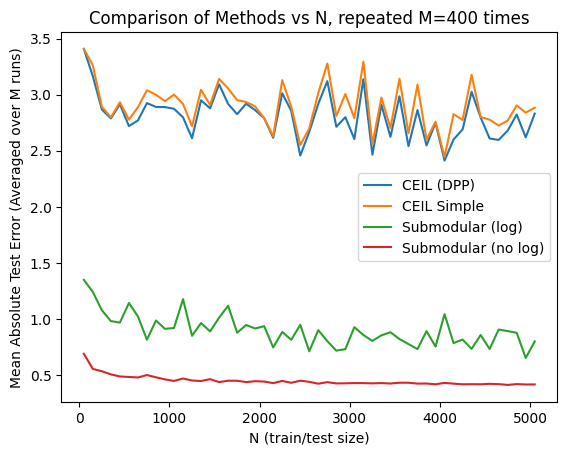

In [3]:
# Cell 3
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Decide if we want to show error bars
show_error_bars = False

# Define the range for N
Ns = range(50, 5051, 100)

# Fixed experimental settings
d = 5
K = 5
lambda_ridge = 0.02
lambda_val   = 1.0
sigma        = 5.0

# Number of repeated runs for each N
M = 400

# Lists to store final aggregated results (one per N)
N_list = []
ceil_dpp_means   = []
ceil_dpp_stds    = []
ceil_simple_means= []
ceil_simple_stds = []
submod_log_means = []
submod_log_stds  = []
submod_nolog_means = []
submod_nolog_stds  = []

# Loop over N values with progress bar
for N in tqdm(Ns, desc="Varying N"):
    # For each N, we'll collect M repeated runs
    all_dpp_means = []
    all_ceil_simple_means = []
    all_submod_log_means = []
    all_submod_nolog_means = []

    for _ in range(M):
        res = experiment(
            d=d,
            N_train=N,
            N_test=N,
            K=K,
            lambda_ridge=lambda_ridge,
            lambda_val=lambda_val,
            sigma=sigma
        )
        all_dpp_means.append(res["ceil_dpp"]["mean_loss"])
        all_ceil_simple_means.append(res["ceil_simple"]["mean_loss"])
        all_submod_log_means.append(res["submodular_log"]["mean_loss"])
        all_submod_nolog_means.append(res["submodular_nolog"]["mean_loss"])

    # Now compute mean across M runs (and std across runs) for each method
    dpp_mean_across_runs = np.mean(all_dpp_means)
    dpp_std_across_runs  = np.std(all_dpp_means)

    ceil_simple_mean_across_runs = np.mean(all_ceil_simple_means)
    ceil_simple_std_across_runs  = np.std(all_ceil_simple_means)

    submod_log_mean_across_runs = np.mean(all_submod_log_means)
    submod_log_std_across_runs  = np.std(all_submod_log_means)

    submod_nolog_mean_across_runs = np.mean(all_submod_nolog_means)
    submod_nolog_std_across_runs  = np.std(all_submod_nolog_means)

    # Store them in the final arrays
    N_list.append(N)
    ceil_dpp_means.append(dpp_mean_across_runs)
    ceil_dpp_stds.append(dpp_std_across_runs)

    ceil_simple_means.append(ceil_simple_mean_across_runs)
    ceil_simple_stds.append(ceil_simple_std_across_runs)

    submod_log_means.append(submod_log_mean_across_runs)
    submod_log_stds.append(submod_log_std_across_runs)

    submod_nolog_means.append(submod_nolog_mean_across_runs)
    submod_nolog_stds.append(submod_nolog_std_across_runs)

# --- Plot results ---
plt.figure()

if show_error_bars:
    plt.errorbar(N_list, ceil_dpp_means,     yerr=ceil_dpp_stds,     label="CEIL (DPP)")
    plt.errorbar(N_list, ceil_simple_means,  yerr=ceil_simple_stds,  label="CEIL Simple")
    plt.errorbar(N_list, submod_log_means,   yerr=submod_log_stds,   label="Submodular (log)")
    plt.errorbar(N_list, submod_nolog_means, yerr=submod_nolog_stds, label="Submodular (no log)")
else:
    plt.plot(N_list, ceil_dpp_means,     label="CEIL (DPP)")
    plt.plot(N_list, ceil_simple_means,  label="CEIL Simple")
    plt.plot(N_list, submod_log_means,   label="Submodular (log)")
    plt.plot(N_list, submod_nolog_means, label="Submodular (no log)")

plt.xlabel("N (train/test size)")
plt.ylabel("Mean Absolute Test Error (Averaged over M runs)")
plt.title(f"Comparison of Methods vs N, repeated M={M} times")
plt.legend()
plt.show()


In [ ]:
# Cell 4
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Decide if we want to show error bars
show_error_bars = False

# Range for sigma
sigma_list = range(1, 15, 2)

# Fixed experimental settings
d = 5
N_train = 200
N_test  = 200
K = 5
lambda_ridge = 0.02
lambda_val   = 1.0

# Number of repeated runs per sigma
M = 400

# Lists for storing final aggregated results
sigma_vals = []
ceil_dpp_means, ceil_dpp_stds = [], []
ceil_simple_means, ceil_simple_stds = [], []
submod_log_means, submod_log_stds = [], []
submod_nolog_means, submod_nolog_stds = [], []

for s in tqdm(sigma_list, desc="Varying sigma"):
    all_dpp_means = []
    all_ceil_simple_means = []
    all_submod_log_means = []
    all_submod_nolog_means = []

    # Repeat M times
    for _ in range(M):
        res = experiment(
            d=d,
            N_train=N_train,
            N_test=N_test,
            K=K,
            lambda_ridge=lambda_ridge,
            lambda_val=lambda_val,
            sigma=s
        )
        all_dpp_means.append(res["ceil_dpp"]["mean_loss"])
        all_ceil_simple_means.append(res["ceil_simple"]["mean_loss"])
        all_submod_log_means.append(res["submodular_log"]["mean_loss"])
        all_submod_nolog_means.append(res["submodular_nolog"]["mean_loss"])

    # Now average across M runs
    dpp_mean_across_runs = np.mean(all_dpp_means)
    dpp_std_across_runs  = np.std(all_dpp_means)

    ceil_simple_mean_across_runs = np.mean(all_ceil_simple_means)
    ceil_simple_std_across_runs  = np.std(all_ceil_simple_means)

    submod_log_mean_across_runs = np.mean(all_submod_log_means)
    submod_log_std_across_runs  = np.std(all_submod_log_means)

    submod_nolog_mean_across_runs = np.mean(all_submod_nolog_means)
    submod_nolog_std_across_runs  = np.std(all_submod_nolog_means)

    sigma_vals.append(s)
    ceil_dpp_means.append(dpp_mean_across_runs)
    ceil_dpp_stds.append(dpp_std_across_runs)

    ceil_simple_means.append(ceil_simple_mean_across_runs)
    ceil_simple_stds.append(ceil_simple_std_across_runs)

    submod_log_means.append(submod_log_mean_across_runs)
    submod_log_stds.append(submod_log_std_across_runs)

    submod_nolog_means.append(submod_nolog_mean_across_runs)
    submod_nolog_stds.append(submod_nolog_std_across_runs)

# --- Plot results ---
plt.figure()

if show_error_bars:
    plt.errorbar(sigma_vals, ceil_dpp_means,     yerr=ceil_dpp_stds,     label="CEIL (DPP)")
    plt.errorbar(sigma_vals, ceil_simple_means,  yerr=ceil_simple_stds,  label="CEIL Simple")
    plt.errorbar(sigma_vals, submod_log_means,   yerr=submod_log_stds,   label="Submodular (log)")
    plt.errorbar(sigma_vals, submod_nolog_means, yerr=submod_nolog_stds, label="Submodular (no log)")
else:
    plt.plot(sigma_vals, ceil_dpp_means,     label="CEIL (DPP)")
    plt.plot(sigma_vals, ceil_simple_means,  label="CEIL Simple")
    plt.plot(sigma_vals, submod_log_means,   label="Submodular (log)")
    plt.plot(sigma_vals, submod_nolog_means, label="Submodular (no log)")

plt.xlabel("sigma")
plt.ylabel("Mean Absolute Test Error (Averaged over M runs)")
plt.title(f"Comparison of Methods vs sigma, repeated M={M} times")
plt.legend()
plt.show()


ValueError: not enough values to unpack (expected 2, got 0)